In [26]:
import xgboost as xg
# import dask.dataframe as dd
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [27]:

#For making pretty LaTeX plots
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 6),
    "figure.dpi": 100,
    "savefig.dpi": 200,
    "savefig.format": "png",
    "savefig.transparent": True,
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "grid.color": "0.8",
    "image.cmap": "Blues",
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "text.usetex": True, "mathtext.fontset": "cm",
    "pgf.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{cmbright}"
})

In [28]:
data = pl.read_csv('../data/preprocessed/engineered_train_set.csv')
display(data)

srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_brand_bool,prop_location_score2,position,srch_destination_id,srch_booking_window,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,has_hist_starrating,has_hist_adr_usd,score1d2,normalized_prop_starrating,normalized_score1d2,normalized_prop_review_score,hotel_quality,normalized_hotel_quality,price_per_person,avg_price_per_day,ump,price_diff,starrating_diff,total_price,promotion_count,promotion_any,price_rank,star_rank
i64,str,i64,i64,str,str,i64,i64,i64,f64,i64,i64,i64,i64,str,f64,i64,i64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,i64,i64,i64,i64
1,null,12,187,null,null,219,893,1,0.0438,27,23246,0,1,null,null,1,0,null,0,0,0,0.015512,-0.093204,-0.193586,0.016094,-0.100568,0.499887,26.1925,104.77,36.404964,null,null,104.77,1,1,3,2
1,null,12,187,null,null,219,10404,1,0.0149,26,23246,0,1,null,null,1,0,null,0,0,0,0.006818,1.211655,-0.702177,0.466714,0.22264,0.537972,42.685,170.74,-17.806987,null,null,170.74,1,1,14,1
1,null,12,187,null,null,219,21315,1,0.0245,21,23246,0,1,null,null,1,0,null,0,0,0,0.011181,-0.093204,-0.446918,0.917334,0.068471,0.519805,44.95,179.8,-42.797387,null,null,179.8,1,1,15,2
1,null,12,187,null,null,219,27348,1,0.0125,34,23246,0,1,null,null,1,0,null,0,0,0,0.004452,-1.398064,-0.84057,0.466714,-0.615633,0.439194,150.6925,602.77,-522.129581,null,null,602.77,1,1,22,3
1,null,12,187,null,null,219,29604,1,0.1241,4,23246,0,1,null,null,1,0,null,0,0,0,0.047044,1.211655,1.651007,0.016094,1.028727,0.632957,35.895,143.58,-5.200488,null,null,143.58,1,1,11,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332785,null,5,219,null,null,219,77700,1,0.0471,2,16974,21,0,null,550.92,0,0,null,0,0,0,0.029315,0.0,-0.035405,0.475379,0.128452,0.526873,39.333333,118.0,-117.0,null,null,118.0,0,0,5,1
332785,null,5,219,null,null,219,88083,1,0.152,3,16974,21,0,null,553.14,0,0,null,0,0,0,0.077996,0.0,1.89005,0.475379,0.898634,0.617627,29.666667,89.0,-88.0,null,null,89.0,0,0,2,1
332785,null,5,219,null,null,219,94508,1,0.0164,4,16974,21,0,null,544.43,0,0,null,0,0,0,0.014999,0.0,-0.60165,0.118845,-0.205007,0.48758,33.0,99.0,-98.0,null,null,99.0,0,0,3,1


Text(0.5, 1.0, 'Histogram of prop_country_id')

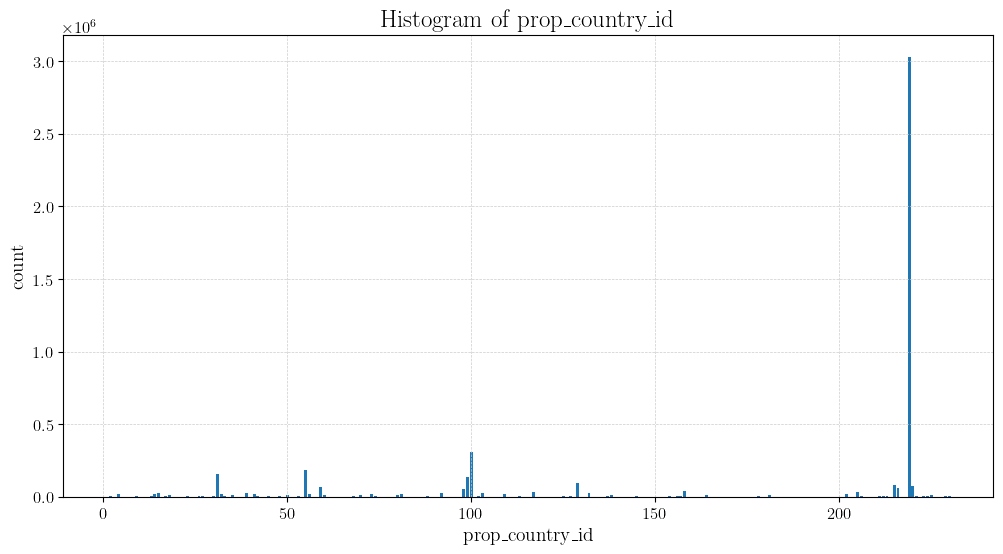

In [29]:
# hist of prop_country_id
count = data['prop_country_id'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(count['prop_country_id'], count['count'])
plt.xlabel('prop_country_id')
plt.ylabel('count')
plt.title('Histogram of prop_country_id')

The following code is very messy, but essentially, all you need to do is choose a number of partitions, after which the variable `partition_list` will be a list of np.arrays, each of which are the `prop_country_id`'s for one partitions. Then you can train a model on each partition

In [30]:
partitions = 12
partitions_list = [np.array([219])]
countries = count['prop_country_id'].to_numpy()
indx = countries != 219
countries = countries[indx]
count_array = count['count'].to_numpy()


# We take a cumsum, and get the indices at which we should split the data, sometimes we get empty partitions
count_array = count_array[indx]
cum_sum = np.cumsum(count_array)
total = cum_sum[-1]
partition_size = total // partitions
for i in range(0, partitions):
    idx_min = np.argmax(cum_sum >= partition_size * i)
    idx_max = np.argmax(cum_sum > partition_size * (i + 1))
    if i == partitions - 1:
        partitions_list.append(countries[idx_min:])
    else:
        partitions_list.append(countries[idx_min:idx_max])

# For printing and getting all the empty partitions
counts = 0
zeros = []
for i, part in enumerate(partitions_list):
    countries = count.filter(count['prop_country_id'].is_in(part))
    part_count = countries['count']
    counts += sum(part_count)
    if i < 9:
        print(f'Count for partion  {i+1}: {sum(part_count)}')
    else:
        print(f'Count for partion {i+1}: {sum(part_count)}')

    if sum(part_count) == 0:
        zeros.append(0)
    else:
        zeros.append(1)

# Remove empty partitions
partitions_list = [x for i, x in enumerate(partitions_list) if zeros[i] == 1]

assert counts == sum(count['count']), f'Expected {sum(count["count"])} but got {counts}'

Count for partion  1: 3030125
Count for partion  2: 157307
Count for partion  3: 160830
Count for partion  4: 58703
Count for partion  5: 188564
Count for partion  6: 155507
Count for partion  7: 0
Count for partion  8: 401258
Count for partion  9: 124191
Count for partion 10: 138753
Count for partion 11: 211331
Count for partion 12: 170835
Count for partion 13: 160943


In [31]:
def split_data_set(data, partitions_list):
    data_partitions = []
    for part in partitions_list:
        data_partitions.append(data.loc[data['prop_country_id'].isin(part)])
    return data_partitions


In [32]:
data = data.sort(['srch_id', 'booking_bool', 'click_bool'], descending=[False, True, True])

In [33]:
# Convert polars DataFrames to pandas DataFrames
data_pd = data.to_pandas()
data_pd['weight'] = 5 * data_pd['booking_bool'] + data_pd['click_bool']
# replace all NULL values with np.nan
data_pd = data_pd.replace('NULL', np.nan)
ranking_pd = data_pd[['srch_id', 'prop_id']]

# Convert object columns to appropriate data types
object_columns = data_pd.select_dtypes(include=['object']).columns
data_pd[object_columns] = data_pd[object_columns].apply(pd.to_numeric, errors='coerce')

# Split the data into features (X) and target (y)
X = data_pd.drop(['srch_id'], axis=1)
y = ranking_pd['prop_id']


# Split the data into training and testing sets based on srch_id
srch_ids = data_pd['srch_id'].unique()
train_srch_ids, test_srch_ids = train_test_split(srch_ids, test_size=0.2, random_state=42)

# Create training and testing DataFrames
train_data = data_pd[data_pd['srch_id'] % 10 != 1]
test_data = data_pd[data_pd['srch_id'] % 10 == 1]

features = [col for col in data.columns if col not in ['srch_id', 'prop_id', 'booking_bool', 'click_bool', 'gross_bookings_usd', 'position', 'relevance_grade', 'date_time', 'orig_destination_distance']]
data = data[features]

split_train = split_data_set(train_data, partitions_list)
split_test = split_data_set(test_data, partitions_list)
split_full = split_data_set(data_pd, partitions_list)

In [34]:
def train_model(data, params, num_boost, drop_cols):
    # Create XGBoost DMatrix objects for training and testing
    train_dmatrix = xg.DMatrix(
        data.drop(drop_cols, axis=1),
        label=data['weight'],
        qid=data['srch_id']
    )
    
    return xg.train(params, train_dmatrix, num_boost_round=num_boost)


def dcg_at_k(r, k, method=1):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 1:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        else:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k, method=1):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def calculate_grades(data):
    data['grade'] = np.where(data['booking_bool'] == 1, 5,
                             np.where(data['click_bool'] == 1, 1, 0))
    return data


def predict_and_evaluate(model, dmatrix, t_data, ndcg=True):
    test_pred = model.predict(dmatrix)
    results_data = t_data.copy()
    results_data['pred'] = test_pred

    # Assign grades based on booking and clicking
    if ndcg:
        results_data = calculate_grades(results_data)

    # Sort predictions with highest probability first
    ordered_results = results_data.sort_values(['srch_id', 'pred'], ascending=[True, False])
    if ndcg:
        grouped = ordered_results.groupby('srch_id')['grade'].apply(list).reset_index()

        ndcg_scores = grouped['grade'].apply(lambda grades: ndcg_at_k(grades, 5))
        mean_ndcg = ndcg_scores.mean()
        print(f'Mean NDCG: {mean_ndcg}')
    
    return ordered_results[['srch_id', 'pred', 'prop_id']], mean_ndcg if ndcg else None


def eval_models_partions(models, split_test, drop_cols, ndcg=True):
    df = pd.DataFrame()
    mean_ndcgs = []
    for model, part in zip(models, split_test):
        dmat = xg.DMatrix(
            part.drop(drop_cols, axis=1), 
            group=part['srch_id'].value_counts().sort_index().values
)
        grouped, mean = predict_and_evaluate(model, dmat, part, ndcg=ndcg)

        df = pd.concat([df, grouped])
        if ndcg:
            mean_ndcgs.append(mean*len(part))
    return df, mean_ndcgs


def train_models(split_train, params, num_boost, drop_cols):
    models = []
    for part in tqdm(split_train):
        model = train_model(part, params, num_boost, drop_cols)
        models.append(model)
    return models

In [41]:
config_pair = {
    'objective': 'rank:pairwise', # the objective, can also be rank:ndcg, but that is buggy
    'lambdarank_pair_method': 'topk', # instead of looking at the mean, we look at the highest k
    'lambdarank_num_pair_per_sample': 6, # set slightly higher than intended k
    'eval_metric': 'ndcg',
    'eta': 0.13963013806537555,
    'max_depth': 9,
    'subsample': 0.7038375178678972,
    'colsample_bytree': 0.7015452447331039,
    'seed': 42
}

config = {
    'objective': 'rank:ndcg',
    'eval_metric': 'ndcg@5',
    'eta': 0.13963013806537555,
    'max_depth': 9,
    'subsample': 0.7038375178678972,
    'colsample_bytree': 0.7015452447331039,
    'seed': 42
}

drop_cols = ['srch_id','prop_id', 'booking_bool', 'gross_bookings_usd', 'position', 'click_bool', 'weight', 'date_time', 'orig_destination_distance']

models_partions = train_models(split_train, config, 120, drop_cols)
model_pair = xg.train(config_pair, xg.DMatrix(train_data.drop(drop_cols, axis=1), label=train_data['weight']), num_boost_round=120)


  0%|          | 0/12 [00:00<?, ?it/s]

In [36]:
model_ndcg = xg.Booster()
model_ndcg.load_model('../scripts/models/final_model.json')

In [43]:
# Evaluate the models
_, part_means = eval_models_partions(models_partions, split_test, drop_cols)
_, mean_pair = predict_and_evaluate(model_pair, xg.DMatrix(test_data.drop(drop_cols, axis=1)), test_data)
_, mean_ndcg = predict_and_evaluate(model_ndcg, xg.DMatrix(test_data.drop(drop_cols, axis=1)), test_data, ndcg=True)

part_mean_performance = sum(part_means) / len(test_data)

df = pd.DataFrame({
    'Model': ['Pairwise', 'NDCG', 'Partitions'],
    'Mean NDCG': [mean_pair, mean_ndcg, part_mean_performance]
})


print(df.to_latex(index=False))


Mean NDCG: 0.44861920969351904
Mean NDCG: 0.347954864656225
Mean NDCG: 0.35699796754833013
Mean NDCG: 0.3817991104488935
Mean NDCG: 0.4540813474556002
Mean NDCG: 0.3698617520896693
Mean NDCG: 0.4030965196632455
Mean NDCG: 0.42733943894057047
Mean NDCG: 0.424908499506761
Mean NDCG: 0.41103049036001477
Mean NDCG: 0.3881138728236419
Mean NDCG: 0.39542035180160945
Mean NDCG: 0.3502865545905981
Mean NDCG: 0.43635435912137094
\begin{tabular}{lr}
\toprule
Model & Mean NDCG \\
\midrule
Pairwise & 0.350287 \\
NDCG & 0.436354 \\
Partitions & 0.429313 \\
\bottomrule
\end{tabular}



In [ ]:
# Full training
models_full = train_models(split_full, config, 120, drop_cols)

In [ ]:
# save the model


for i, model in enumerate(models_full):
    model.save_model(f'models/model_{i}.json')
# load the model
models_full = [xg.Booster() for i in range(len(partitions_list))]
[models_full[i].load_model(f'models/model_{i}.json') for i in range(len(models_full))]


In [ ]:
test_set = pl.read_csv('../data/preprocessed/engineered_test_set.csv')
test_set = test_set.to_pandas()
test_set = test_set.replace('NULL', np.nan)

object_columns = test_set.select_dtypes(include=['object']).columns
test_set[object_columns] = test_set[object_columns].apply(pd.to_numeric, errors='coerce')

split_eval = split_data_set(test_set, partitions_list)

assert sum([len(x) for x in split_eval]) == len(test_set)

In [ ]:
test_set.head()

In [ ]:
drop_cols = ['srch_id','prop_id']
grouped, mean = eval_models_partions(models_full, split_eval, ndcg=False, drop_cols=drop_cols)

In [ ]:
submission = grouped[['srch_id', 'prop_id']]

assert len(submission) == len(test_set)

submission.head()

In [ ]:
submission.to_csv('submit/submission.csv', index=False)

# old stuff for single model


test_set_dmatrix = xg.DMatrix(test_set.drop(['srch_id'], axis=1), group=test_set['srch_id'].value_counts().sort_index().values)
test_set['pred'] = model.predict(test_set_dmatrix)

# same as earlier, without need for calculating the ndcg, so less steps
submission = test_set.sort_values(['srch_id', 'pred'], ascending=[True, False])[['srch_id', 'prop_id']]
submission.to_csv('submit/submission.csv', index=False)

test_set = pl.read_csv('../data/preprocessed/engineered_test_set.csv')
shuffled_test_set = test_set.sort(['srch_id', 'price_per_person'], descending=[False, True])[['srch_id', 'prop_id']]


shuffled_test_set.write_csv('submit/submission.csv')